# **Denoising AutoEncoder as Preprocessing for Classification**


# Exercise Description

In this exercise I will use the MNIST Dataset to implement a denoising autoencoder and use it as a preprocessing step for a classification task. I will follow the next steps:

**For the Autoencoder as preprocessing:**
1.   Define the dataloader over data during training phase.
2.   Define the encoder and decoder, using ReLU (hidden layers) and Sigmoid (output layer) as activation functions.
3.   Train the model applying Adam Optimizer and MSE as the loss function.
4.   Finally, I will compare the results using the corrupted image, the reconstructed image and the original image.

**Classification Comparison:**
1.   Using the denoising images I will train a simple classifier and see the results.
2.   Using the original images I will train another simple classifier.
3.   Compare the results of the classification task between the denoising images and the original ones.
---

# Abstract

# **AutoEncoders**
Autoencoders are a specialized class of algorithms that can learn efficient representations of input data with no need for labels. It is a class of artificial neural networks designed for unsupervised learning. Learning to compress and effectively represent input data without specific labels is the essential principle of an automatic decoder. This is accomplished using a two-fold structure that consists of an encoder and a decoder. The encoder transforms the input data into a reduced-dimensional representation, which is often referred to as “latent space” or “encoding”. From that representation, a decoder rebuilds the initial input. For the network to gain meaningful patterns in data, a process of encoding and decoding facilitates the definition of essential features.

# **Architecture**
The general architecture of an autoencoder includes an encoder, decoder, and bottleneck layer.

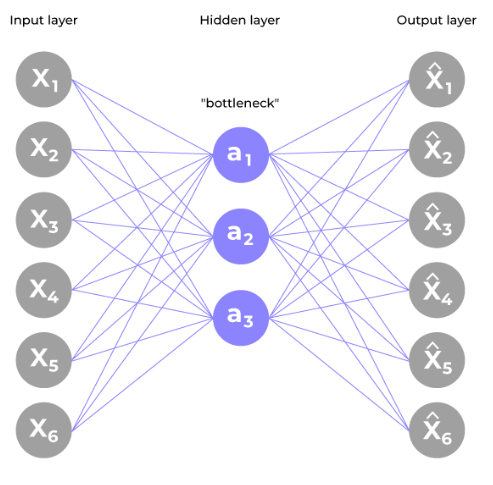


**Encoder:**

*   Input layer take raw input data.
*   The hidden layers progressively reduce the dimensionality of the input, capturing important features and patterns.



**The bottleneck layer (latent space):**

*   Is the final hidden layer, where the dimensionality is significantly reduced. This layer represents the compressed encoding of the input data.


**Decoder:**

*   The bottleneck layer takes the encoded representation and expands it back to the dimensionality of the original input.
*   The hidden layers progressively increase the dimensionality and aim to reconstruct the original input.
*   The output layer produces the reconstructed output, which ideally should be as close as possible to the input data.


The loss function used during training is typically a reconstruction loss, measuring the difference between the input and the reconstructed output.
During training, the autoencoder learns to minimize the reconstruction loss, forcing the network to capture the most important features of the input data in the bottleneck layer.


# **Denoising Autoencoder (DAE)**
A denoising autoencoder is a modification of the original autoencoder in which instead of giving the original input we give a corrupted or noisy version of input to the encoder while decoder loss is calculated concerning original input only. This results in efficient learning of autoencoders and the risk of autoencoder becoming an identity function is significantly reduced.

As mentioned above, this method is an effective way to constrain the network from simply copying the input and thus learn the underlying structure and important features of the data.

**Advantages:**
*   This type of autoencoder can extract important features and reduce the noise or the useless features.
*   Denoising autoencoders can be used as a form of data augmentation, the restored images can be used as augmented data thus generating additional training samples.


**Disadvantages:**
*   Selecting the right type and level of noise to introduce can be challenging and may require domain knowledge.
*   Denoising process can result into loss of some information that is needed from the original input. This loss can impact accuracy of the output.

#1. Download the dataset



In [1]:
import torch.utils.data
from torchvision import datasets, transforms
import numpy as np
import pandas as pd

from torch import nn, optim

# set GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#2. Define Dataloader



In [2]:
from torch.utils.data import dataloader

#Normalize data to 0-1
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(0,1)])

#Load MNIST Dataset
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)


#Define batchs and loader
batch_size = 128
train_loader = dataloader.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = dataloader.DataLoader(test_data, batch_size=batch_size, shuffle=True)

#print dataset information
print('Train data size:', len(train_data))
print('Test data size:', len(test_data))

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.13MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 65.9kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:06<00:00, 241kB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.97MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Train data size: 60000
Test data size: 10000


#3. Define the AutoEncoder Model



In [3]:
#Architecture of the model
#Encoder: 3 fully connected layer (fc1, fc2, fc3)
#Decoder: 3 fully connected layer (fc4, fc5, fc6)
#RELU: activation function for hidden layers
#Sigmoid: activation function for output layer

class DAE(nn.Module):
  def __init__(self):
    super().__init__()

    #layers for encoder
    self.fc1 = nn.Linear (784, 512)
    self.fc2 = nn.Linear (512, 256)
    self.fc3 = nn.Linear (256, 128)

    #layers for decoder
    self.fc4 = nn.Linear (128, 256)
    self.fc5 = nn.Linear (256, 512)
    self.fc6 = nn.Linear (512, 784)

    #activation function
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()

  def encode(self, x):
    #x is the noisy input
    #pass x trough the encoder layers (fc1, fc2, fc3)
    h1 = self.relu(self.fc1(x))
    h2 = self.relu(self.fc2(h1))
    return self.relu(self.fc3(h2))

  def decode(self, z):
    #the input is the encoded representation z
    #pass z trough the decoder layers (fc4, fc5, fc6)
    #the result is passed to the sigmoid function to get values from 0 to 1
    h4 = self.relu(self.fc4(z))
    h5 = self.relu(self.fc5(h4))
    return self.sigmoid(self.fc6(h5))

  def forward(self, x):
    #define the forward stesp, first the encode and then the decode
    q = self.encode(x.view(-1, 784))
    return self.decode(q)



#4. Define Training Function



In [15]:
def train (epoch, model, train_loader, optimizer, cuda=True, save_denoised = False):
  model.train()
  #initialize train loss
  train_loss = 0
  denoised_data = []
  original_labels = []

  for batch_idx, (data, target) in enumerate (train_loader):
    data = data.to(device)
    optimizer.zero_grad()

    #input with noise
    data_noise = torch.randn(data.shape).to(device)
    data_noise = data + data_noise

    #calculate loss function between the reconstructed output and the original input
    recon_batch = model(data_noise.to(device))
    loss = criterion(recon_batch, data.view(data.size(0), -1).to(device))
    loss.backward()

    train_loss += loss.item() * len(data)
    optimizer.step()


    if save_denoised:  # Save denoised data
      denoised_data.append(recon_batch.cpu().detach())
      original_labels.append(target.cpu())


    if batch_idx % 100 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item() / len(data)))


  print('==== Epoch: {} Average loss: {:.4f}'.format(
      epoch, train_loss / len(train_loader.dataset)))

  if save_denoised:
    denoised_data = torch.cat(denoised_data)
    original_labels = torch.cat(original_labels)
    return denoised_data, original_labels

    return None, None

#5. Define Optmizer and Model

In [16]:
epochs = 10

#create instance of the model
model = DAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.MSELoss()


#train the model
denoised_data, original_labels = None, None
for epoch in range(1, epochs + 1):
  if epoch == epochs:  # In the last epoch, save the data obtained
      denoised_data, original_labels = train(epoch, model, train_loader, optimizer, save_denoised=True)
  else:
      train(epoch, model, train_loader, optimizer)


#DataLoader with denoised data
denoised_dataset = torch.utils.data.TensorDataset(denoised_data, original_labels)
denoised_loader = torch.utils.data.DataLoader(denoised_dataset, batch_size=batch_size, shuffle=True)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.001809
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.000446
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.000394
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.000346
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.000324
==== Epoch: 1 Average loss: 0.0520
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.000338
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.000332
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.000305
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.000328
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.000298
==== Epoch: 2 Average loss: 0.0405
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.000322
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.000310
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.000296
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.000289
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.000313
==== Epoch: 3 Average loss: 0.0390
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.000310
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.000295
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.000278
Train Epoch: 4 

#6. Plot images

Image {0} with label {2}
Image {1} with label {2}
Image {2} with label {7}
Image {3} with label {0}
Image {4} with label {1}


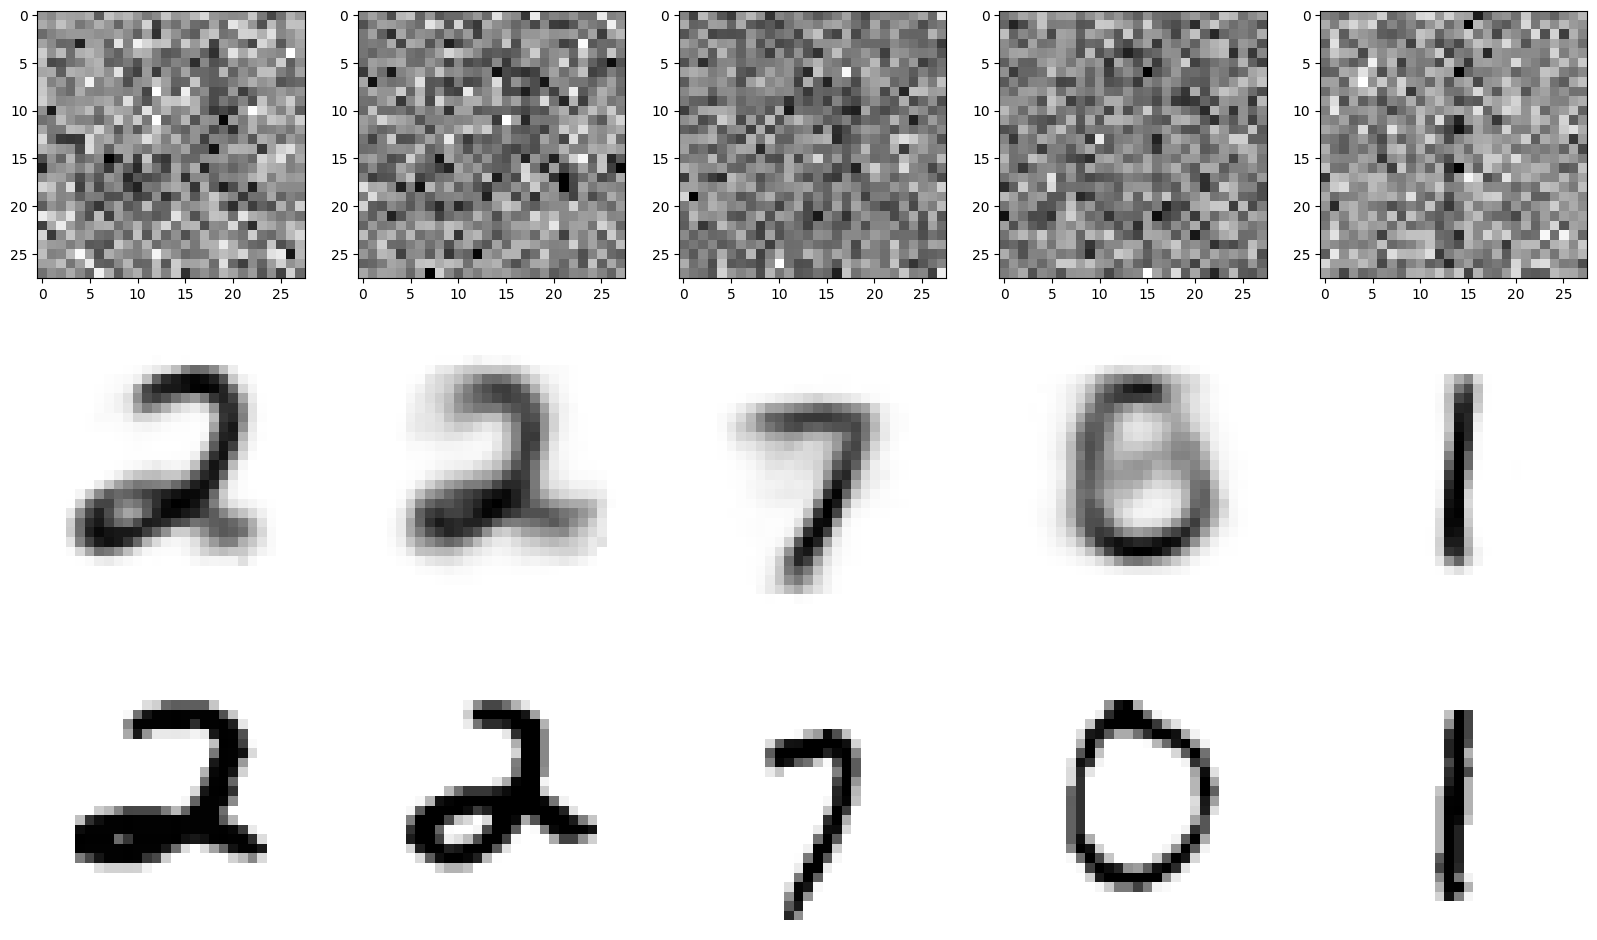

In [17]:
import matplotlib.pyplot as plt
for batch_idx, (data, labels) in enumerate(test_loader):
    data = data.to(device)
    optimizer.zero_grad()

    data_noise = torch.randn(data.shape).to(device)
    data_noise = data + data_noise

    recon_batch = model(data_noise.to(device))
    break


#print 5 images
plt.figure(figsize=(20, 12))
for i in range(5):
    print("Image {"+str(i)+"} with label {"+str(labels[i].item())+"}")
    plt.subplot(3, 5, 1+i)
    plt.imshow(data_noise[i, :, :, :].view(28, 28).cpu().detach().numpy(), cmap='binary')
    plt.subplot(3, 5, 6+i)
    plt.imshow(recon_batch[i, :].view(28, 28).cpu().detach().numpy(), cmap='binary')
    plt.axis('off')
    plt.subplot(3, 5, 11+i)
    plt.imshow(data[i, :, :, :].view(28, 28).cpu().detach().numpy(), cmap='binary')
    plt.axis('off')
plt.show()

# **Classification Process**

In [18]:
# Classifer Model
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)  # 10 classes for MNIST
        self.relu = nn.ReLU()
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.log_softmax(self.fc3(x))
        return x

def train_classifier(model, train_loader, optimizer, criterion, epochs=5):
    model.train()
    for epoch in range(1, epochs + 1):
        total_loss = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data.view(data.size(0), -1))
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print(f"Epoch {epoch}/{epochs}, Loss: {total_loss / len(train_loader)}")


def evaluate_classifier(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data.view(data.size(0), -1))
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
    accuracy = correct / total
    print(f"Accuracy: {accuracy * 100:.2f}%")
    return accuracy


In [19]:
#Classifiers instances
classifier_original = Classifier().to(device)
classifier_denoised = Classifier().to(device)

#Optimizer and Loss Function
optimizer_original = optim.Adam(classifier_original.parameters(), lr=1e-3)
optimizer_denoised = optim.Adam(classifier_denoised.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

#Classifier for original data
print("Training classifier on original data...")
train_classifier(classifier_original, train_loader, optimizer_original, criterion, epochs=5)

#Classifier for denoised data
print("\nTraining classifier on denoised data...")
train_classifier(classifier_denoised, denoised_loader, optimizer_denoised, criterion, epochs=5)

#Evaluate
print("\nEvaluating classifier trained on original data:")
accuracy_original = evaluate_classifier(classifier_original, test_loader)

print("\nEvaluating classifier trained on denoised data:")
accuracy_denoised = evaluate_classifier(classifier_denoised, test_loader)


Training classifier on original data...
Epoch 1/5, Loss: 0.3516558235102117
Epoch 2/5, Loss: 0.13747837638327562
Epoch 3/5, Loss: 0.09142383027162507
Epoch 4/5, Loss: 0.06614817377688216
Epoch 5/5, Loss: 0.04925081479762282

Training classifier on denoised data...
Epoch 1/5, Loss: 0.8678651976941237
Epoch 2/5, Loss: 0.7749925019390294
Epoch 3/5, Loss: 0.7638217671466535
Epoch 4/5, Loss: 0.7543515473413569
Epoch 5/5, Loss: 0.751678103831277

Evaluating classifier trained on original data:
Accuracy: 97.59%

Evaluating classifier trained on denoised data:
Accuracy: 91.25%


# Final Results

In this exercise I implement a denoising autoencoder for the MNIST dataset to use it as a preprocessing step for a classifier task. Then, I compare the results obtained with the classification on the original data.

 **Analysis**


Regarding the autoencoder model:
*   The autoencoder model is able to reconstruct the original image compared to the actual image with only 10 epochs of training, proving good results for denoising images.
*   The average loss of 0.0369 in the denoising autoencoder is low considering that the loss function used is Mean Squared Error (MSE), which indicates a very small difference between the reconstructed and original images. This means that the reconstructions are not only visually acceptable, but also close to the original images at the pixel level.

Regarding the classification process:
*  The classifier trained on original MNIST data achieved a high accuracy of 97.59%, which aligns with expectations for a simple fully connected neural network on the MNIST dataset.
*  The classifier trained on the denoised data achieved a lower accuracy of 91.25%. While the model still performs reasonably well, there is a noticeable drop compared to the classifier trained on original data.
*  The reduced accuracy for the denoised data highlights that the quality of the reconstructions from the Denoising Autoencoder (DAE) is not perfect. Although the DAE helps remove noise, it likely loses some important details that are critical for classification tasks.

# Future Work
For the future work, I can suggest to improve the autoencoder model using for instance, convolutional layers instead of fully connected layers, which could lead to better reconstructions and preserve more fine-grained details.